In [297]:
import sys
sys.path.insert(0,'C:\\code\\masters_thesis\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import requests
import random
import bs4 as bs
import datetime
import yfinance as yf
# from pandas_datareader import data as pdr
# from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader
from pandas_datareader.yahoo.daily import YahooDailyReader
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import minimize

"""
Own packages
"""

# from codelib.statistics.moments import corr_to_cov_matrix
from codelib.population_parameters import calculate_mean, calculate_cov_mat
from codelib.portfolio_measures import portfolio_mean, portfolio_variance, portfolio_std
from codelib.portfolio_performance_measures import sharpe_ratio

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [322]:
start_date = datetime.datetime(1991, 1, 1)

# Riskfree rate

In [323]:
# get one-month US T-bill rate
reader = FamaFrenchReader("F-F_Research_Data_Factors", start=start_date)
ff_factors = reader.read()

# print details
# ff_factors['DESCR']

# get monthly risk-free rate (US one month T-Bill return)

us_tbill = pd.DataFrame(ff_factors[0]['RF'])

# FamaFrench data

In [316]:
# load data
reader = FamaFrenchReader("10_Industry_Portfolios", start=start_date)
ind_port = reader.read()

# print details
# ind_port['DESCR']

In [355]:
# get value and equally weighted industry portfolios
ind_mc_weighted = ind_port[0] #value weighted
ind_eq_weighted = ind_port[1] #equally weighted

# remove whitespace form column names
ind_eq_weighted.columns = [_.strip() for _ in ind_eq_weighted.columns]
ind_mc_weighted.columns = [_.strip() for _ in ind_mc_weighted.columns]

In [356]:
# calculate monthly return-premiums (monthly returns minus one-month US T-bill rate)

monthly_returns = ind_mc_weighted
monthly_return_premiums = monthly_returns.sub(us_tbill['RF'], axis=0)

In [365]:
monthly_return_premiums.to_csv(r'C:\code\masters_thesis\data\sp500_monthly_return_premiums.csv')
monthly_return_premiums

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1991-01,4.63,6.77,5.94,-2.57,14.45,-0.33,8.83,4.02,-1.89,6.96
1991-02,9.81,9.75,5.39,8.04,5.93,2.94,7.82,9.39,4.36,9.20
1991-03,4.34,0.72,0.94,0.88,0.31,1.89,8.14,4.98,1.27,2.66
1991-04,-1.50,-2.88,0.00,1.93,-3.43,0.59,1.44,-1.67,-0.57,0.75
1991-05,3.13,14.25,7.01,-1.88,3.14,-1.92,7.18,4.18,-0.32,4.49
...,...,...,...,...,...,...,...,...,...,...
2022-08,-2.08,-5.96,-3.67,3.13,-5.37,-3.20,-3.31,-5.26,-0.10,-3.01
2022-09,-8.51,-6.87,-11.70,-9.31,-11.59,-14.13,-7.80,-2.10,-11.84,-8.10
2022-10,9.71,-6.50,11.99,23.37,4.62,10.71,4.07,8.61,3.27,11.37


# 20 random stocks from S&P500

In [303]:
# get 'adjusted close' stock prices from 20 random stocks in S&P500 (I found random tickers in another notebook)
tickers = ['ACGL','ADM','AIG','ALK','AOS','BSX','CL','CPRT','EXC','GE','HD','HIG','HST','JBHT','KO','MAS','MGM','SJM','SNA','TROW']

start_date = datetime.date(1996, 1, 1)
end_date = datetime.date(2022, 1, 2)
SP500_adj_close = yf.download(tickers, start=start_date, end=end_date, interval='1mo')['Close']

[*********************100%***********************]  20 of 20 completed


In [304]:
# remove time from date index
SP500_adj_close.index = pd.to_datetime(SP500_adj_close.index.date)

In [314]:
SP500_adj_close.head()

,ACGL,ADM,AIG,ALK,AOS,BSX,CL,CPRT,EXC,GE,HD,HIG,HST,JBHT,KO,MAS,MGM,SJM,SNA,TROW
1996-01-01,2.263889,14.178093,459.259247,4.9375,2.791667,12.81250,9.250000,0.619792,10.966476,76.812988,10.222222,25.0625,11.257954,3.90625,18.84375,12.851494,7.37500,20.750,29.333332,6.75000
1996-02-01,2.250000,14.364646,459.259247,5.5625,2.694444,12.00000,9.781250,0.583333,10.074893,75.561958,9.611111,25.7500,12.726383,4.56250,20.18750,12.521968,8.31250,20.125,29.833332,6.71875
1996-03-01,2.277778,13.711708,443.851837,6.6875,2.625000,11.50000,9.734375,0.515625,9.495364,77.938911,10.611111,24.5000,13.215859,4.93750,20.68750,12.741652,9.59375,22.250,31.166668,6.62500
1996-04-01,2.208333,14.084816,433.185181,6.3750,2.555556,10.78125,9.578125,0.567708,8.826676,77.313400,10.527778,24.1875,13.093490,5.09375,20.37500,11.972759,10.90625,21.125,32.000000,6.96875
1996-05-01,2.194444,14.551200,446.814819,6.5000,2.972222,10.71875,9.843750,0.354167,8.782097,82.817909,11.361111,25.8750,12.848752,4.75000,23.00000,13.730228,11.37500,20.375,32.083332,7.00000


In [306]:
# calculate monthly returns (note: index is one month ahead, maybe change startdate to 31-12-1995?)
SP500_monthly_returns = ((SP500_adj_close / SP500_adj_close.shift(1) - 1) * 100).dropna()
SP500_monthly_returns.head()

,ACGL,ADM,AIG,ALK,AOS,BSX,CL,CPRT,EXC,GE,HD,HIG,HST,JBHT,KO,MAS,MGM,SJM,SNA,TROW
1996-02-01,-0.613505,1.315783,0.000000,12.658228,-3.482616,-6.341463,5.743243,-5.882453,-8.130081,-1.628670,-5.978266,2.743142,13.043486,16.800000,7.131012,-2.564106,12.711864,-3.012048,1.704546,-0.462963
1996-03-01,1.234574,-4.545451,-3.354839,20.224719,-2.577301,-4.166667,-0.479233,-11.607095,-5.752208,3.145701,10.404625,-4.854369,3.846153,8.219178,2.476780,1.754386,15.413534,10.559006,4.469282,-1.395349
1996-04-01,-3.048800,2.721090,-2.403202,-4.672897,-2.645483,-6.250000,-1.605136,10.100948,-7.042256,-0.802566,-0.785337,-1.275510,-0.925931,3.164557,-1.510574,-6.034479,13.680782,-5.056180,2.673793,5.188679
1996-05-01,-0.628939,3.311253,3.146377,1.960784,16.304320,-0.579710,2.773246,-37.614583,-0.505054,7.119735,7.915564,6.976744,-1.869155,-6.748466,12.883436,14.678898,4.297994,-3.550296,0.260413,0.448430
1996-06-01,-0.632866,-1.923078,4.641906,5.288462,-6.542047,4.956268,7.619048,-2.941272,5.583755,4.833834,5.623476,2.898551,-0.952379,9.868421,6.521739,-3.200000,-12.362637,-3.680982,-1.558442,9.821429


# Analysis

In [325]:
# choose dataset
data = monthly_return_premiums

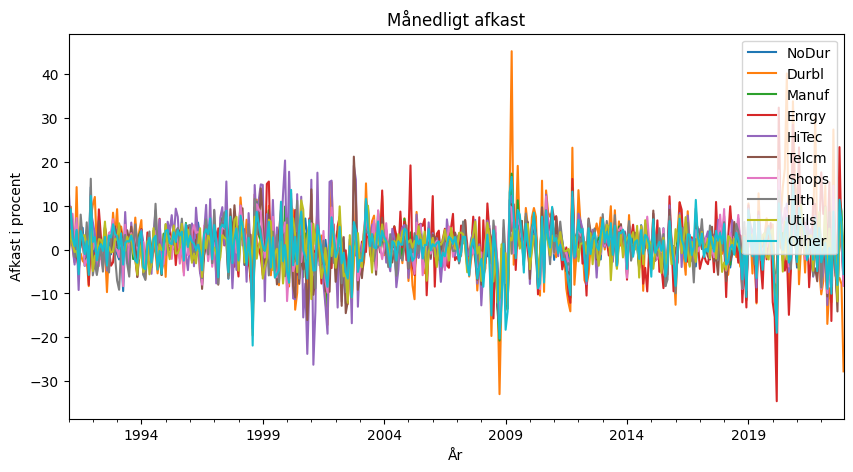

In [326]:
# plot monthly returns
ax = data.plot(title="Månedligt afkast", figsize=(10, 5), xlabel="År");
ax.set_ylabel('Afkast i procent');

In [327]:
# calculate population parameters mu and sigma: here mean returns and covariance matrix of returns

mu = np.mean(data, axis=0)
print(mu)
cov_mat = np.cov(data.T) #normalized by N-1 by default
print(cov_mat)

NoDur    0.722604
Durbl    0.845026
Manuf    0.838490
Enrgy    0.812865
HiTec    1.024870
Telcm    0.492005
Shops    0.816432
Hlth     0.806094
Utils    0.653490
Other    0.752995
dtype: float64
[[14.39096448 15.35768662 13.52443371 11.78159461 11.69327841 11.60231905
  12.02199104 10.77705224  8.44244859 14.38970262]
 [15.35768662 65.20442663 29.00266479 23.93598426 33.11074517 22.23070974
  26.05479109 15.11206799 10.27872524 30.67523791]
 [13.52443371 29.00266479 23.43073401 20.0291012  22.95987735 16.69132967
  17.30656823 12.92170505  9.07929954 22.01819931]
 [11.78159461 23.93598426 20.0291012  43.54833851 16.87587635 15.34753941
  12.30587709 10.33276187 12.6480717  19.81496842]
 [11.69327841 33.11074517 22.95987735 16.87587635 46.22271748 22.94470561
  21.72633883 15.43797573  6.06599184 22.88715822]
 [11.60231905 22.23070974 16.69132967 15.34753941 22.94470561 25.8081696
  15.18974451 12.02755772  8.15521518 18.57303784]
 [12.02199104 26.05479109 17.30656823 12.30587709 21.726

In [328]:
# calculate volatilities and correlation matrix

vols = np.sqrt(np.diag(cov_mat))
corr_mat = cov_mat / np.outer(vols, vols)
print(corr_mat)

[[1.         0.50135149 0.73651431 0.4706232  0.4533813  0.60203432
  0.68600967 0.64952063 0.55061367 0.73167736]
 [0.50135149 1.         0.74200429 0.44918677 0.60311854 0.54192126
  0.69847014 0.42788126 0.3149374  0.73276066]
 [0.73651431 0.74200429 1.         0.62702191 0.69766812 0.67876492
  0.77395695 0.6103301  0.46406938 0.87740802]
 [0.4706232  0.44918677 0.62702191 1.         0.37614284 0.45779849
  0.40366916 0.35798806 0.47420054 0.57918904]
 [0.4533813  0.60311854 0.69766812 0.37614284 1.         0.6643182
  0.69176343 0.51915917 0.22074842 0.64934706]
 [0.60203432 0.54192126 0.67876492 0.45779849 0.6643182  1.
  0.64724791 0.54129842 0.39717357 0.70520777]
 [0.68600967 0.69847014 0.77395695 0.40366916 0.69176343 0.64724791
  1.         0.57861595 0.34216968 0.7797012 ]
 [0.64952063 0.42788126 0.6103301  0.35798806 0.51915917 0.54129842
  0.57861595 1.         0.40172564 0.63674382]
 [0.55061367 0.3149374  0.46406938 0.47420054 0.22074842 0.39717357
  0.34216968 0.401725

# Max sharpe portfolio

In [329]:
# find optimal MV portfolio (max sharpe) (unknown weights: x), rf=0
rf = 0

# define constraints: sum-to-one and long-only
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1, 'jac' : lambda w: np.ones_like(w)},
               {'type': 'ineq', 'fun' : lambda w: w, 'jac' : lambda w: np.eye(len(w))})

# set initial value
equal_weights = np.ones_like(mu) / len(mu)

res = minimize(fun = sharpe_ratio, args=(mu, cov_mat, rf),
               x0 = equal_weights,
               method = 'SLSQP',
               constraints = constraints,
               options={'ftol': 1e-9, 'disp': True})
w_m = res.x
print(np.round(w_m,4))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2236221402341458
            Iterations: 16
            Function evaluations: 176
            Gradient evaluations: 16
[ 0.1991 -0.      0.      0.0064  0.0949 -0.      0.1444  0.252   0.3032
 -0.    ]


In [330]:
# calculate expected return, variance and Sharpe-ratio for the true optimal MV portfolio

mu_m = portfolio_mean(w_m, mu)
print("mu_m = " + str(mu_m))
var_m = portfolio_variance(w_m, cov_mat)
print("sigma^2_m = " + str(var_m))
std_m = portfolio_std(w_m, cov_mat)
print("sigma_m = " + str(std_m))
sr_m = - sharpe_ratio(w_m, mu, cov_mat)
print("SR_m = " + str(sr_m))

mu_m = 0.7654916061903366
sigma^2_m = 11.717939905948423
sigma_m = 3.423147660552846
SR_m = 0.2236221402341458


In [331]:
# simulate returns for (num_obs) t=60, 100, 300, 500, 1000 months
# find optimal portfolio weights for each simulation (1000 in total)

rf = 0
num_sim = 1000
num_obs = 60 # months
np.random.seed(2)
sim_data = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_obs))

mu_est = np.mean(sim_data, axis=1)
w_sim = list()

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1, 'jac' : lambda w: np.ones_like(w)},
               {'type': 'ineq', 'fun' : lambda w: w, 'jac' : lambda w: np.eye(len(w))})

equal_weights = np.ones_like(mu) / len(mu)

for i in range(num_sim):

    cov_mat_est = np.cov(sim_data[i], rowvar=False)

    res = minimize(fun = sharpe_ratio, args=(mu_est[i], cov_mat_est, rf),
                   x0 = equal_weights,
                   method = 'SLSQP',
                   constraints = constraints)
    w_sim.append(res.x)

w_sim = np.array(w_sim)

In [332]:
print(mu)
print(mu_est[0]) # estimate over one simulation is far from true values
np.mean(mu_est, axis=0)

NoDur    0.722604
Durbl    0.845026
Manuf    0.838490
Enrgy    0.812865
HiTec    1.024870
Telcm    0.492005
Shops    0.816432
Hlth     0.806094
Utils    0.653490
Other    0.752995
dtype: float64
[ 0.25661094  1.44197866  0.58829987  0.46213284 -0.09531157  0.06855945
  0.83559063  0.10500908  0.45653793  0.26916048]


array([0.72071576, 0.82454331, 0.83165103, 0.82105894, 1.00542018,
       0.48323267, 0.81877727, 0.80768922, 0.65660975, 0.73876789])

In [333]:
# calculate estimated expected return and variance for simulated MV portfolios

mu_sim_est = list()
var_sim_est = list()

for i in range (num_sim):
    mean = portfolio_mean(w_sim[i], mu_est[i])
    cov_mat_est = np.cov(sim_data[i], rowvar=False)
    var = portfolio_variance(w_sim[i], cov_mat_est)

    mu_sim_est.append(mean)
    var_sim_est.append(var)

In [334]:
# calculate average return, variance and SR for simulated MV portfolios

av_mu_sim_est = np.mean(mu_sim_est)
print(av_mu_sim_est)
av_std_sim_est = np.mean(np.sqrt(var_sim_est))
print(av_std_sim_est)
sr_sim_est = av_mu_sim_est / av_std_sim_est
print(sr_sim_est)

1.2766078261905296
4.0133314363555845
0.3180918013962456


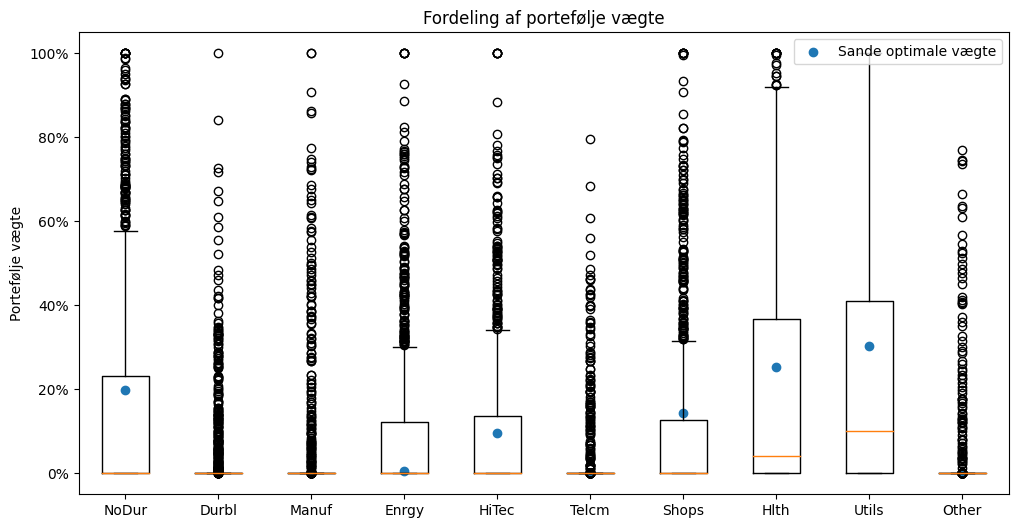

In [335]:
# boxplot of simulated optimal portfolio weights

fig, ax = plt.subplots(figsize=(12, 6))

ax.boxplot(w_sim);

ax.set_xticklabels(data.columns)
ax.scatter(np.arange(len(w_m)) + 1, w_m, label="Sande optimale vægte")

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

ax.legend();
ax.set_ylabel("Portefølje vægte")
ax.set_title("Fordeling af portefølje vægte");

In [336]:
# calculate actual expected return and variance for the simulated MV portfolios
mu_sim = list()
var_sim = list()

for i in range (num_sim):
    mean = portfolio_mean(w_sim[i], mu)
    var = portfolio_variance(w_sim[i], cov_mat)
    mu_sim.append(mean)
    var_sim.append(var)

In [337]:
# calculate average of actual return, variance and SR for simulated portfolios

av_mu_sim = np.mean(mu_sim)
print("\nE(mu_sim) = " + str(av_mu_sim))
av_var_sim = np.mean(var_sim)
print("E(var_sim) = " + str(av_var_sim))
av_std_sim = np.mean(np.sqrt(var_sim))
sr_sim = av_mu_sim / av_std_sim
sr_sim


E(mu_sim) = 0.7755243401307648
E(var_sim) = 17.877661908296897


0.1858426974410013

In [338]:
# calculate true return and variance for equally weighted portfolio

mu_eq_port = portfolio_mean(equal_weights, mu)
print(mu_eq_port)
var_eq_port = portfolio_variance(equal_weights, cov_mat)
print(var_eq_port)
std_eq_port = portfolio_std(equal_weights, cov_mat)
sr_eq_port = mu_eq_port / np.sqrt(var_eq_port)
sr_eq_port

0.7764869791666666
17.404893498524533


0.1861223350273183

In [339]:
# calculate mean and variance for simulated optimal parameters w, mu, sigma and sr
# not used for anything right now!!

# portfolio weights
mean_w_sim = np.mean(w_sim, axis=0)
print("E(w_sim) = " + str(mean_w_sim))
var_w_sim = np.var(w_sim, axis=0)
print("Var(w_sim) = " + str(var_w_sim))

# portfolio returns
mean_mu_sim = np.mean(mean_sim)
print("\nE(mu_sim) = " + str(mean_mu_sim))
var_mu_sim = np.var(mean_sim)
print("Var(mu_sim) = " + str(var_mu_sim))

# portfolio variance
mean_var_sim = np.mean(var_sim)
print("\nE(var_sim) = " + str(mean_var_sim))
var_var_sim = np.var(mean_sim)
print("Var(var_sim) = " + str(var_var_sim))

# sharpe-ratio
mean_sr_sim = np.mean(sr_sim)
print("\nE(sr_sim) = " + str(mean_sr_sim))
var_sr_sim = np.var(sr_sim)
print("Var(sr_sim) = " + str(var_sr_sim))

# true optimal parameters
print("\nmu_m = " + str(mean_m))
print("sigma^2_m = " + str(var_m))
print("SR_m = " + str(sr_m))

E(w_sim) = [0.15472484 0.03440859 0.03960953 0.09505456 0.09835634 0.02359841
 0.10429823 0.19927428 0.22904938 0.02162583]
Var(w_sim) = [0.06547563 0.01047341 0.01823783 0.03296374 0.03065474 0.00722955
 0.03974273 0.06880742 0.07677232 0.00869483]

E(mu_sim) = 0.7777047667365651
Var(mu_sim) = 0.00505610578034306

E(var_sim) = 17.877661908296897
Var(var_sim) = 0.00505610578034306

E(sr_sim) = 0.1858426974410013
Var(sr_sim) = 0.0

mu_m = 0.7670770467780894
sigma^2_m = 11.717939905948423
SR_m = 0.2236221402341458


# Plot results in graph with true efficient frontier

In [340]:
# find minimum variance portfolio

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1, 'jac' : lambda w: np.ones_like(w)},
               {'type': 'ineq', 'fun' : lambda w: w, 'jac' : lambda w: np.eye(len(w))})

# set initial value
equal_weights = np.ones_like(mu) / len(mu)

res = minimize(fun = portfolio_variance, args=(cov_mat),
               x0 = equal_weights,
               method = 'SLSQP',
               constraints = constraints,
               options={'ftol': 1e-9, 'disp': True})
w_mv = res.x
print(np.round(w_mv,4))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.02327558309134
            Iterations: 11
            Function evaluations: 127
            Gradient evaluations: 11
[ 0.2732  0.      0.     -0.     -0.      0.0158  0.1318  0.1857  0.3934
  0.    ]


In [341]:
mu_mv = portfolio_mean(w_mv, mu)
std_mv = np.sqrt(portfolio_variance(w_mv, cov_mat))

# tangency portfolio
w_max_sr = w_m

mu_max_sr = mu_m
std_max_sr = std_m

# efficient portfolios
alpha = np.linspace(-5.0, 1.0, 1000)

w_eff = w_mv[:, None] * alpha[None, :] + w_max_sr[:, None] * (1-alpha[None, :])

std_eff = np.apply_along_axis(portfolio_std, 0, w_eff, (cov_mat))
mu_eff = np.apply_along_axis(portfolio_mean, 0, w_eff, (mu))

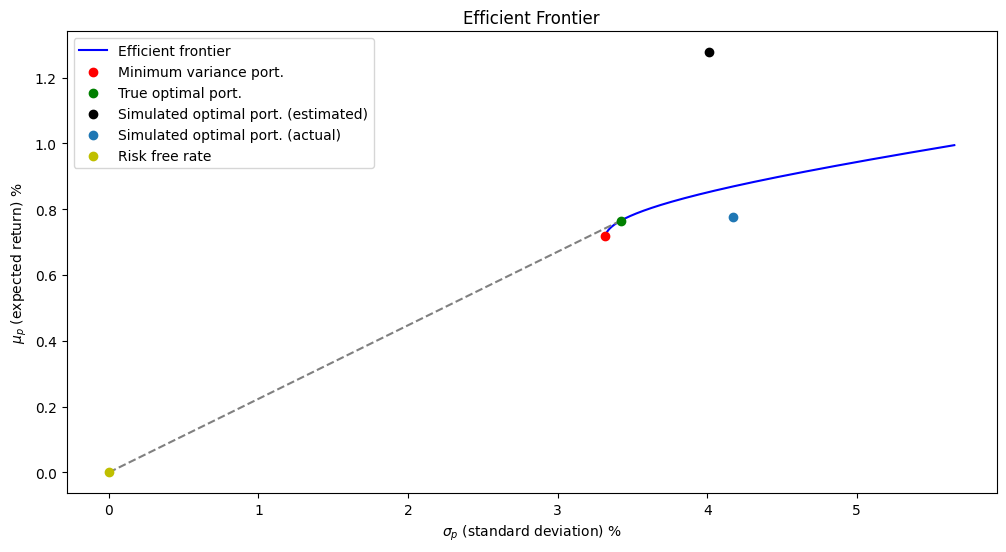

In [350]:
"""
Plot the efficient frontier
"""

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(std_eff, mu_eff, color="blue", label="Efficient frontier")
ax.plot([0.0, std_max_sr], [rf, mu_max_sr], color="gray", linestyle="--")
ax.scatter(std_mv, mu_mv, color="red", label="Minimum variance port. ", zorder=10)
ax.scatter(std_max_sr, mu_max_sr, color="green", label="True optimal port. ", zorder=10)
ax.scatter(av_std_sim_est, av_mu_sim_est, color="black", label="Simulated optimal port. (estimated)")
ax.scatter(av_std_sim, av_mu_sim, label="Simulated optimal port. (actual)")
ax.scatter(0, rf, color="y", label="Risk free rate", zorder=10)

ax.set_title("Efficient Frontier")
ax.set_xlabel("$\sigma_p$ (standard deviation) %")
ax.set_ylabel("$\mu_p$ (expected return) %")

ax.legend();